# Probabilistic Machine Learning
<div style="text-align: right"> University of Tübingen, Summer Term 2023  &copy; 2023 P. Hennig </div>

## Exercise Sheet No. 1 — Setting Up


---

Submission by:
*  Sam, Laing: 6283670
*Albert, Catalan, 6443478

In [52]:
from io import StringIO

import pandas as pd
import requests
from jax import numpy as jnp
from matplotlib import pyplot as plt
from matplotlib import ticker

from tueplots import bundles
from tueplots.constants.color import rgb

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi": 200})

# Exercise 1.2 (Coding Exercise)

This week's exercise serves as an opener for the course. As a first step, make sure the cell above this works for you. This is mostly to ensure you have `jax` and `tueplots` installed in your local environment, which we will use across the course. If you get errors, try a `pip install jax tueplots pandas`. Consider the well-known Mauna Loa CO$_2$ dataset, which we download directly from [NOAA](https://gml.noaa.gov/ccgg/trends/data.html): 

In [53]:
url = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_weekly_mlo.csv"
s = requests.get(url).text

df = pd.read_csv(StringIO(s), sep=",", header=51, na_values="-999.99").dropna()
X = df["decimal"]
Y = df["average"]

We do a *very* quick and dirty linear regression on this univariate timeseries.

In [54]:
phi = jnp.stack([jnp.ones(len(X)), jnp.asarray(X)])
w = jnp.linalg.solve((phi @ phi.T), phi @ Y)
Ypred_LinReg = w[0] + w[1] * X


def loss(Yhat):
    return jnp.sqrt(((Y - Yhat) ** 2).mean())


print(f"simple linear regression has train RMSE {loss(Ypred_LinReg):0.2f}")

simple linear regression has train RMSE 3.08


And make a nice plot:

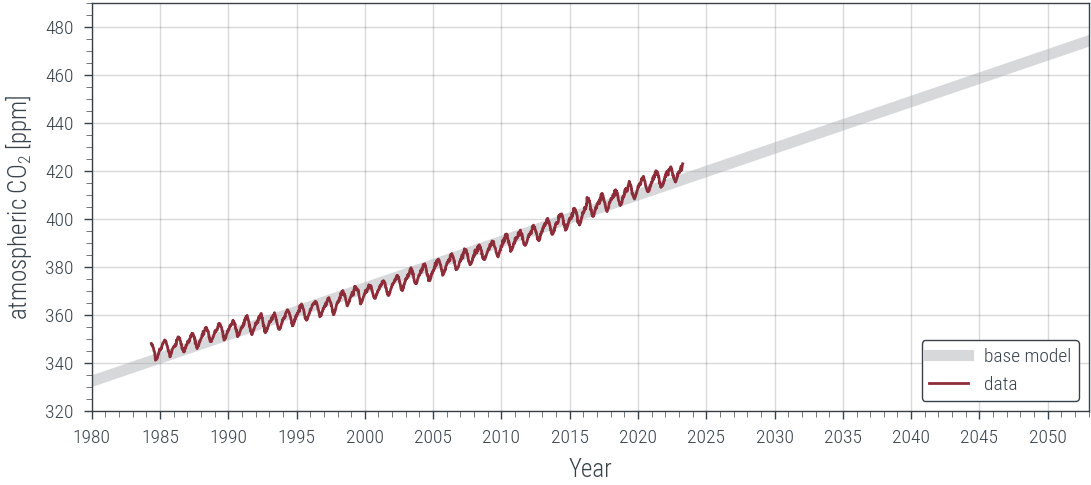

In [55]:
fig, ax = plt.subplots()
x = jnp.linspace(1980, 2053, 200)
ax.plot(x, w[0] + w[1] * x, color=rgb.tue_gray,
        lw=4, alpha=0.5, label="base model")
ax.plot(X, Y, label="data")

ax.set_xlabel("Year")
ax.set_ylabel("atmospheric CO$_2$ [ppm]")
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.set_xlim([1980, 2053])
ax.set_ylim([320, 490])
ax.grid(which="major", axis="both")
ax.legend(loc="lower right", framealpha=1, facecolor="w");

## Your Task:

Using your favorite deep learning framework, define and train a supervised (regression) model on this dataset `X,Y`. Use it to predict on the test inputs `x = jnp.linspace(1980, 2053, 200)` from above, i.e. 30 years into the future. Consider the following aspects:
* Does your model interpolate between the data (i.e. does it predict the actual pairs $(x_i,y_i)$ correctly, or just approximately)?
* Which structural aspects of the data does your model capture (e.g., does its extrapolation also capture the seasonal oscillations present in the data?
* Do you know a way to add a form of *confidence* or *uncertainty* to the prediction? Can you make *worst/best-case* and *most likely* predictions for atmospheric CO$_2$ over the next 30 years?

**Note:** There is obviously no unique "correct" answer to this task. The goal of this exercise is to allow you to reflect on what you may have heard in previous courses about state-of-the-art machine learning models and their training. Deep learning is often perceived as having replaced all of machine learning, and it certainly permeates most of it. However, while deep learning models have led to impressive results on applications like natural language processing and computer vision, they remain nontrivial to train and to interpret; and their extrapolatory behaviour can be underwhelming. Much of the lecture course will be dedicated to understanding models, their training and predictive behaviour better, and to transfer much of what we learn with basic models to deep learning. 

Thus, we do not expect you to provide a perfect answer here. Answers will get the "sufficient" mark (i.e. the associated bonus point in the exam) if they 
* correctly define any model with at least one nonlinearity
* train the model such that its RMSE on the train set (as defined above) is *smaller* than that of linear regression. 
* amend the plot above with the model's prediction on the testset `x` (not the train set!)

In [56]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

In [85]:
# making the training data torch tensors 

X = np.array(X)
X = torch.from_numpy(X.reshape(-1,1)).float()

Y = np.array(Y)
Y = torch.from_numpy(Y.reshape(-1,1)).float()

print(X.shape, Y.shape)

torch.Size([1999, 1]) torch.Size([1999, 1])


In [ ]:
class Model(nn.Module):
    def __init__(self, nInput=1, nOutput=1, nLayer = 4, nHidden = 20, act_fn = nn.ReLU()):
        super().__init__()
        layers = []
        layers += [nn.Linear(nInput, nHidden)]
        layers += [nn.BatchNorm1d(nHidden)]
        layers += [act_fn]
        for _ in range(nLayer):
            layers += [nn.Linear(nHidden, nHidden)]
            layers += [nn.BatchNorm1d(nHidden)]
            layers += [act_fn]
        layers += [nn.Linear(nHidden, nOutput)]
        self.model = nn.Sequential(*layers)   
        print(layers)

    def forward(self, x):
        #x = torch.flatten(x,1)
        return self.model(x)



model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.015)
loss_fn = nn.MSELoss()

loss = 1.5
c = 0

# stop training when loss is half of linear regression 
# since it meets assignment requirements
while loss >= 1.5:
    if c % 500 == 0:
        print(loss)
    
    Y_pred = model.forward(X)

    optimizer.zero_grad()
    loss = loss_fn(Y_pred,Y.float())
    loss.backward()
    optimizer.step()
    c+=1



In [254]:
print(loss_fn(Y_pred, Y.float()))

tensor(1.4998, grad_fn=<MseLossBackward0>)


This is how the model performs on the Training data:

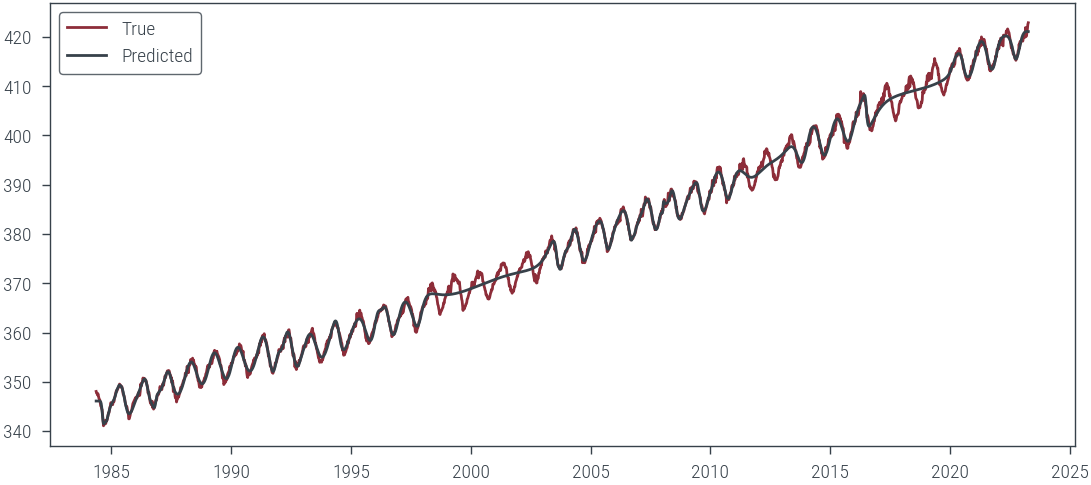

In [246]:
plt.plot(X, Y.detach(), label='True')
plt.plot(X, Y_pred.detach(), label='Predicted')
plt.legend()
plt.show()

In [242]:
# test data:
x = np.array(jnp.linspace(2023, 2053, 200))
x = torch.from_numpy(x.reshape(-1,1)).float()

y = np.array(model.forward(x).detach())

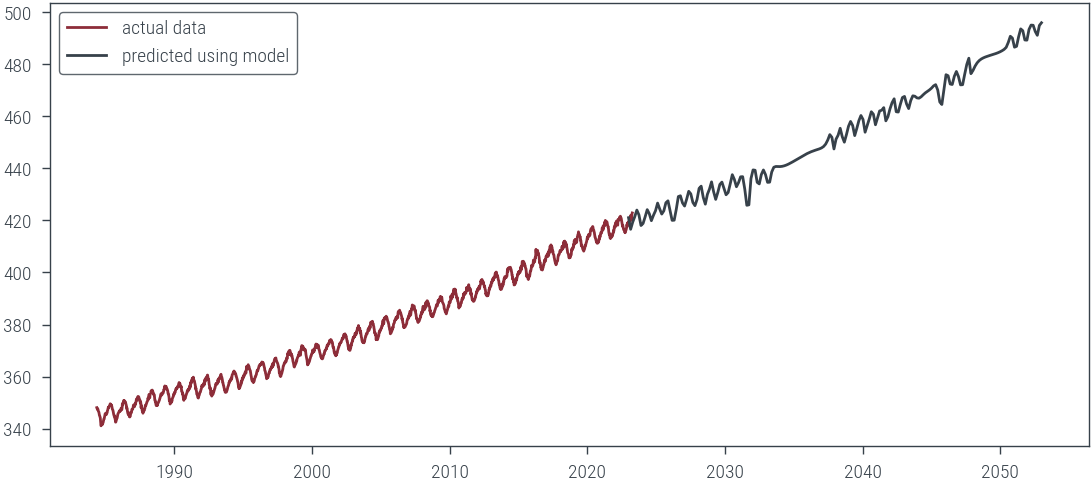

In [249]:
# plot of how the model predicts 
plt.plot(X, Y.detach(), label='actual data')
plt.plot(x,y, label = "predicted using model")

plt.legend()
plt.show()

### How to submit your work:

Export your answer into a pdf (for example using jupyter's `Save and Export Notebook as` feature in the `File` menu). Make sure to include all outputs, in particular plots. Also include your answer to the theory question, either by adding it as LaTeX code directly in the notebook, or by adding it as an extra page (e.g. a scan) to the pdf. Submit the exercise on Ilias, in the associated folder. **Do not forget to add your name(s) and matricel number(s) above!)**